# Mesoscopic Model
## Getting Started

* The mesoscopic model implementation is in `src/mesoscopic_model.py`
* Analysis are in `ana/meso_helper.py`
* and some higher-level wrappers to create the figures from the paper are in `ana/paper_plots.py`
* We have a script that wraps the model to generate the needed data, in `run/meso_launcher.py`

But first, lets explore the model a bit:

In [1]:
# the model and helpers are in `src` and `ana` folders
import sys
sys.path.append("./../")
from ana import paper_plots as pp
from ana import meso_helper as mh
from src import mesoscopic_model as mm

# To explore the parameters of the mesoscopic model, try the following:
# list the parameter description
print(mm.simulate_model.__doc__)
 # and default values
mm.default_pars 


    Simulate the mesoscopic model with the given parameters.

    # Parameters:
    simulation_time: float
        Duration of the simulation in arbitrary units. use 1000 as a starting point

    gating_mechanism  : bool, optional
        Control whether the gating mechanism is used (default: True).
        If False, gates are not updated and activity can pass at all times.

    max_rsrc : float, optional
        Maximum amount of synaptic resources.

    tau_charge : float, optional
        Timescale of synaptical resource charging
    tau_discharge : float, optional
        Timescale of synaptical resource discharge

    tau_rate : float, optional
        Timescale of firing rate (activity) going to zero (exponential decay)

    sigma : float, optional
        Strenght of background noise fluctuations

    w0 : float, optional
        Coupling strenght between different nodes

    tau_disconnect : float, optional
        Timescale of gate becoming inactive, thus not letting activity

<class 'dict'>
├── gating_mechanism .................................................... bool  True
├── max_rsrc ........................................................... float  1.0
├── tau_charge ......................................................... float  40.0
├── tau_discharge ...................................................... float  5.0
├── tau_rate ........................................................... float  1.0
├── sigma .............................................................. float  0.1
├── w0 ................................................................. float  0.01
├── tau_disconnect ..................................................... float  1.0
├── tau_connect ........................................................ float  20.0
├── ext_str ............................................................ float  0.0
├── k_inpt ............................................................. float  1.6
├── thrs_inpt ...........................................

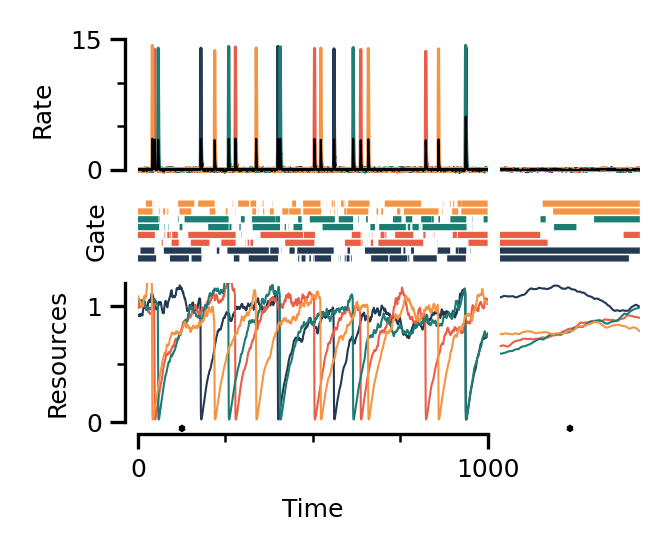

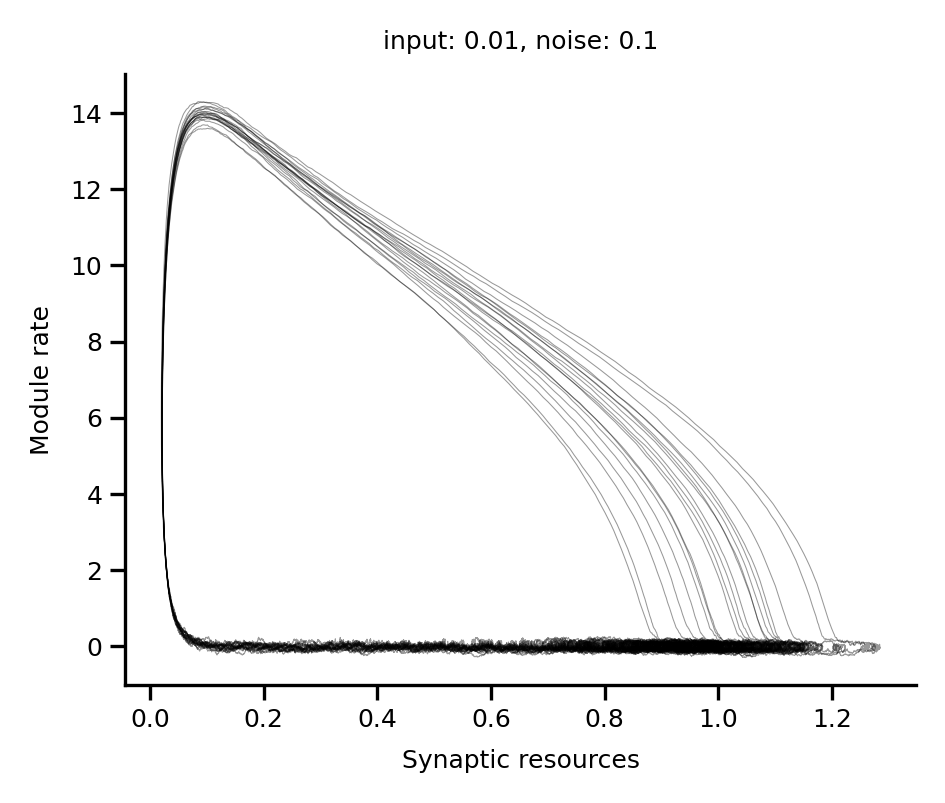

In [6]:
# tweak some of the parameters and get a quick-and-dirty representation of the run
pp.meso_explore(
    # kwargs are passed through to the `mm.simulate_model`
    simulation_time=1000,
    ext_str=0.01,
    w0=0.01,
    gating_mechanism=True
);

## Generating Data

Simulations of the mesoscopic model are pretty fast, the most extensive ones can be run on a laptop over night.

We have the `run/meso_launcher.py` script that uses the model from above, and creates output files in `dat/simulations/meso/raw` or `raw_long_ts` (see the script file for details).

To analyse

In [ ]:
# for the phase plots, the short time series are sufficient.
# the long ones are mainly for plotting resource cycles.
dset = mh.process_data_from_folder(f"{pp.p_sim}/meso/raw/")
mh.write_xr_dset_to_hdf5(dset, output_path=f"{pp.p_sim}/meso/processed/analysed.hdf5")

## Plots from the paper


    Wrapper for Figure 5 (extended) on Mesoscopic model containing
    - As a function of increasing External input h:
        * Module-level correlation coefficients (mean)"
            - for different coupling values (low coupling light, high coupling dark)
            - Note that this is only loosely comparable to the rij of the neuron model
            as those were pairwise correlations.
        * The average number of modules that contributed in an event (like in Fig 4)
            - one panel for each coupling value
            - dark blue: 4 modules, ... light: 1 module
    - A sketch of the Resrouces vs Probability to disconnect.

    


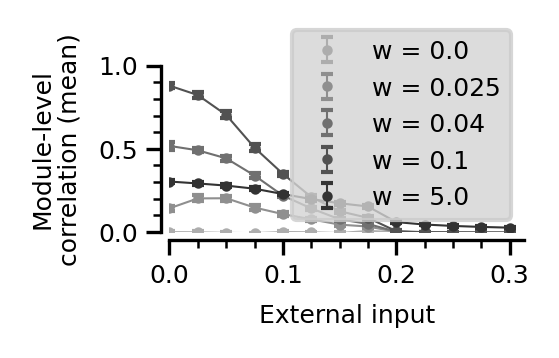

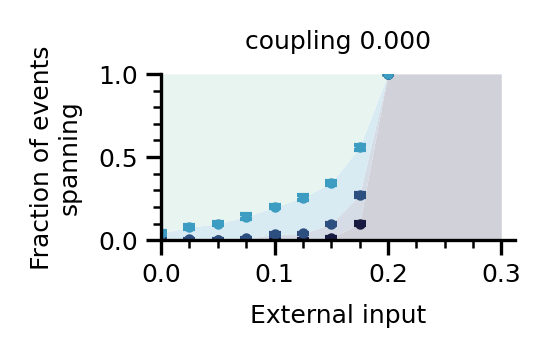

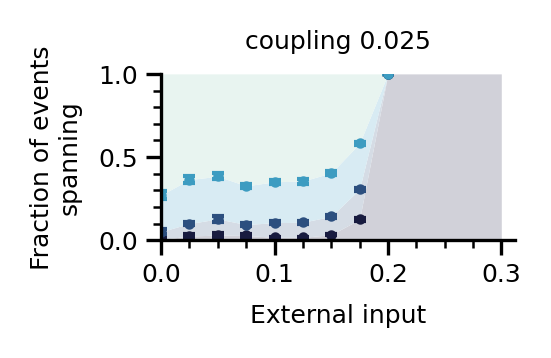

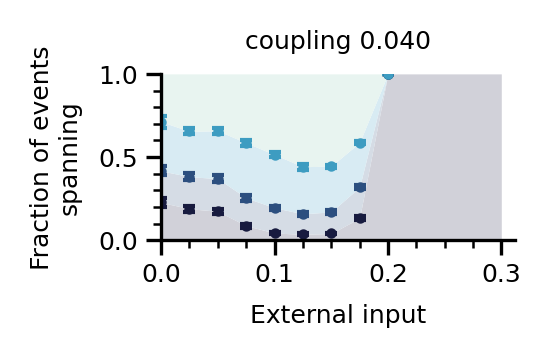

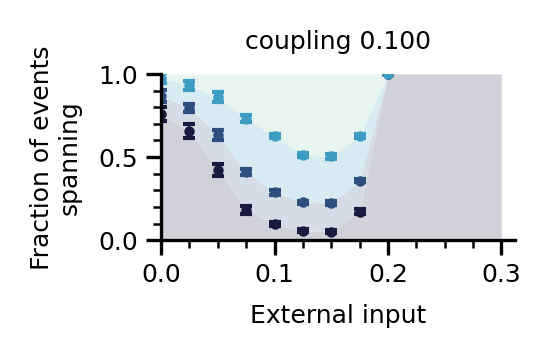

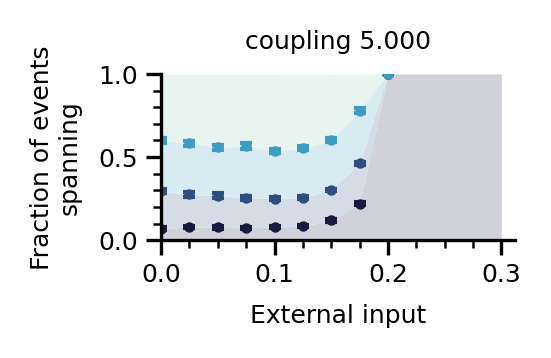

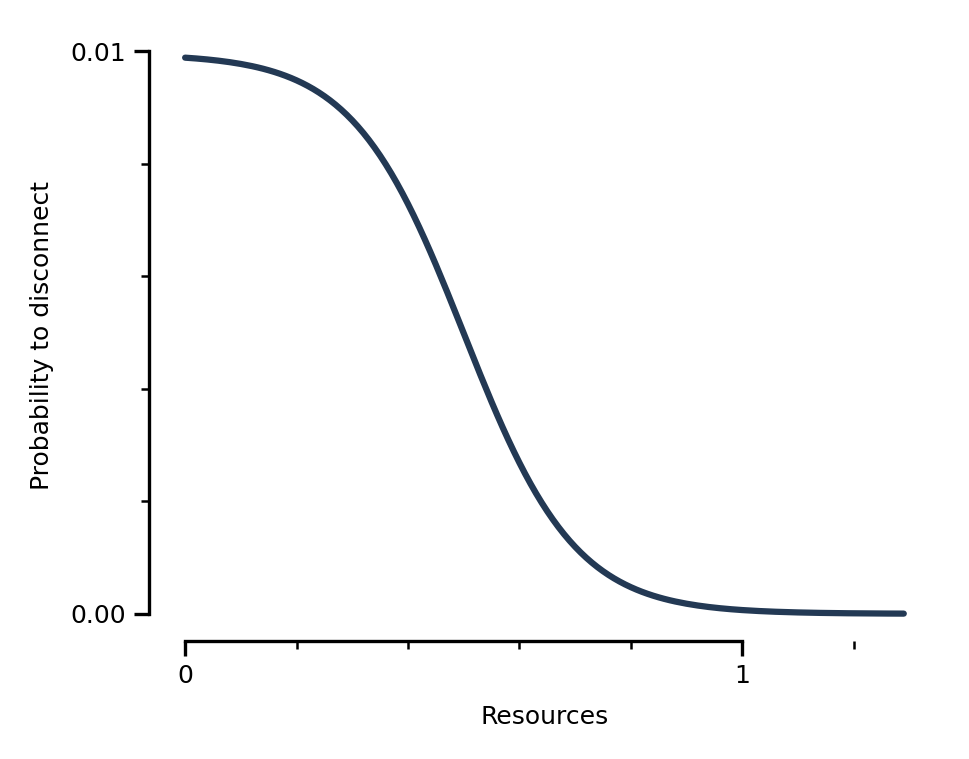

In [3]:
# Note: to get the version with gates disabled, manually provide the right
# file paths / loaded dset
print(pp.fig_5.__doc__)
pp.fig_5()


    Analogous to fig_4, we created snapshots of the time series of the mesoscopic
    model and the resource cycles.

    * Timeseries
        - top: Global average (black) and module-level Firing rates (colored by mod)
        - middle: state of the gates going out from each (colored) module, the colored
            bar indicates when the gate is connected and activity can pass
        - bottom: Available synaptic resources.
        - right, inset: zoom of all panels at the position marked by the black dot.
    * Cycles:
        - uses detectied time points of bursts ending,
        to depcit full charge-discharge repetition in the module-rate vs
        resources plane.
        - see also `ph.plot_resources_vs_activity`
    


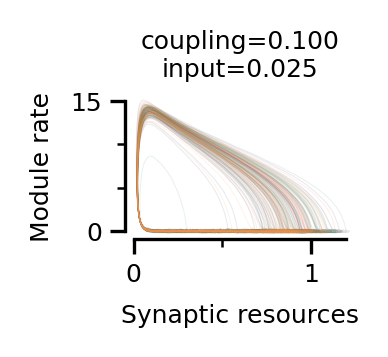

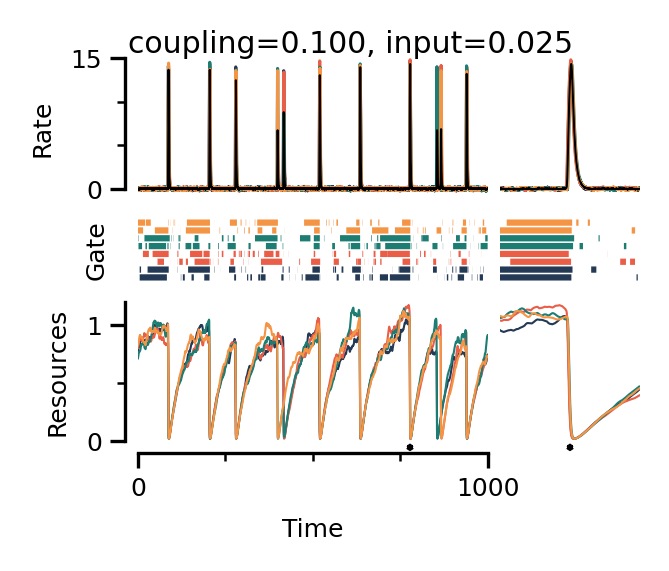

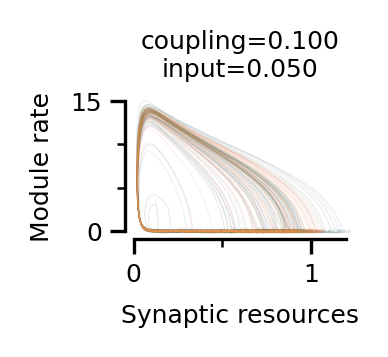

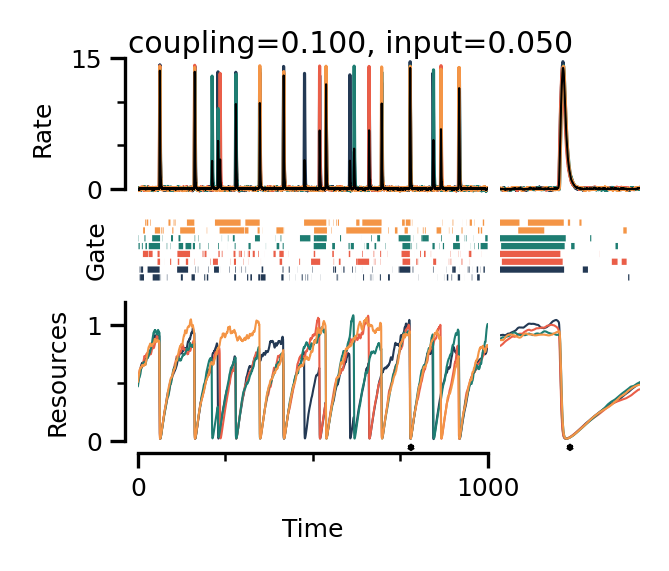

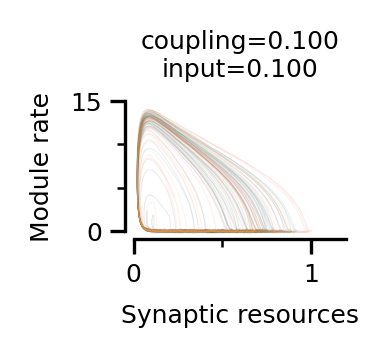

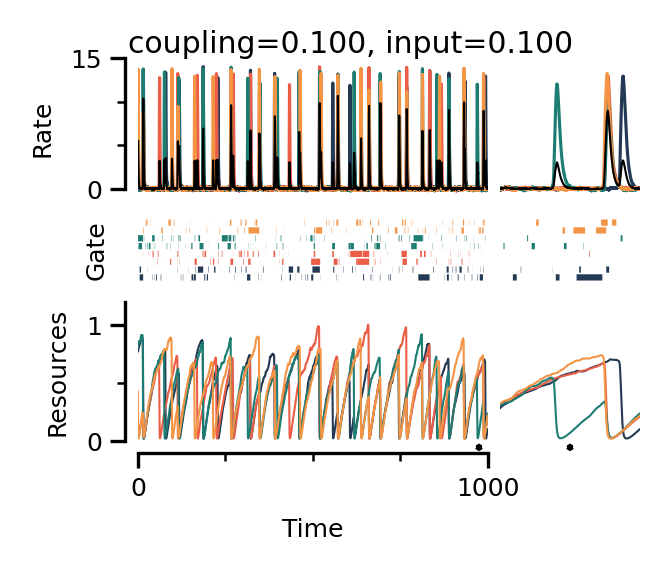

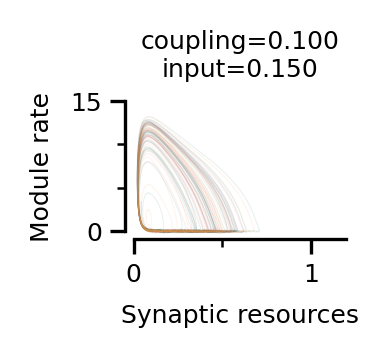

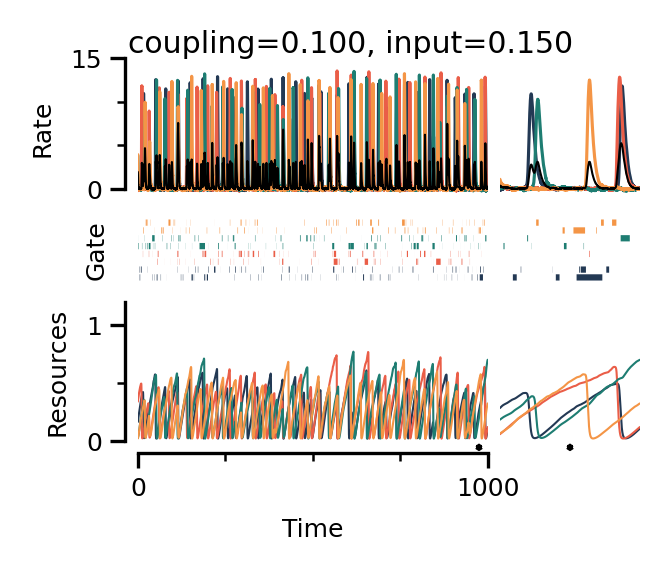

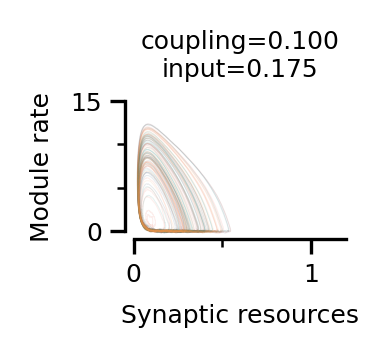

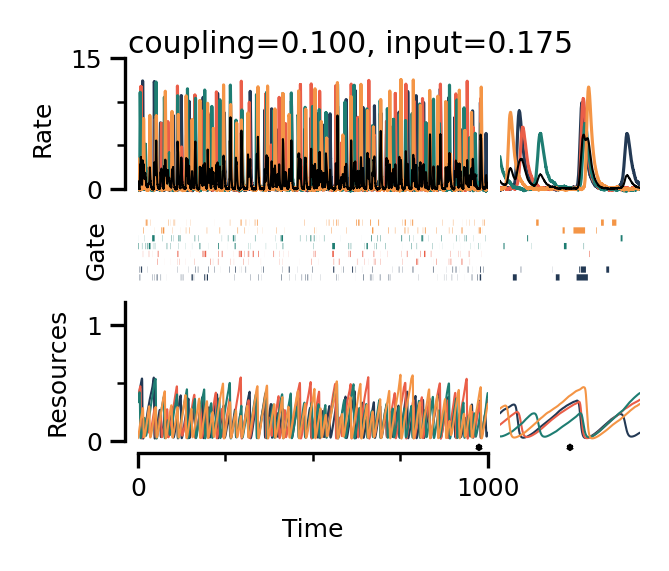

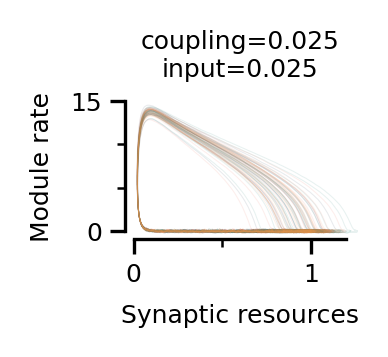

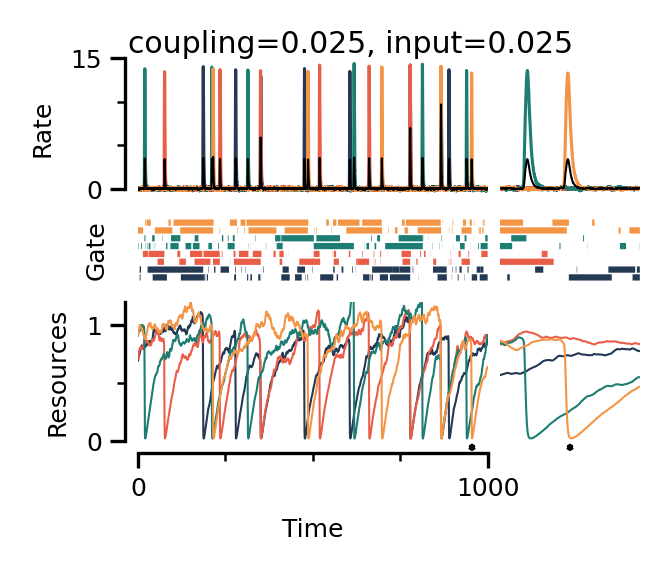

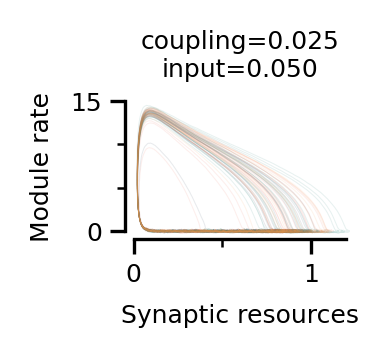

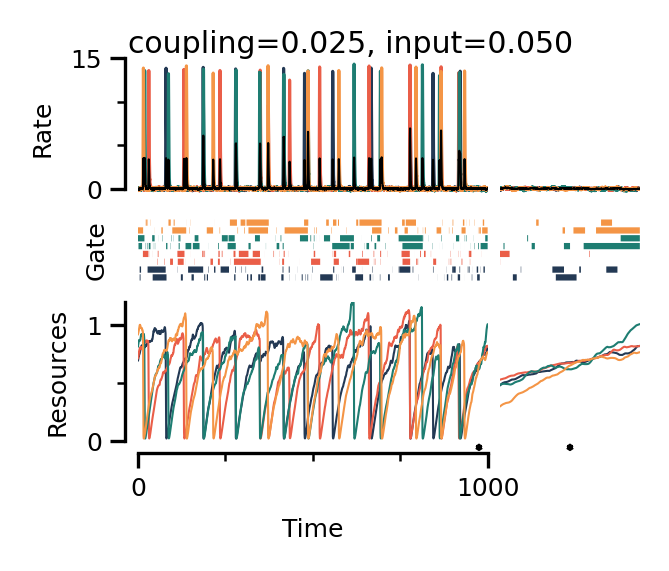

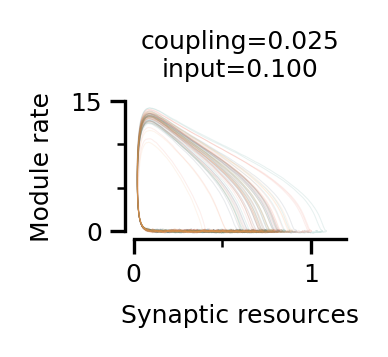

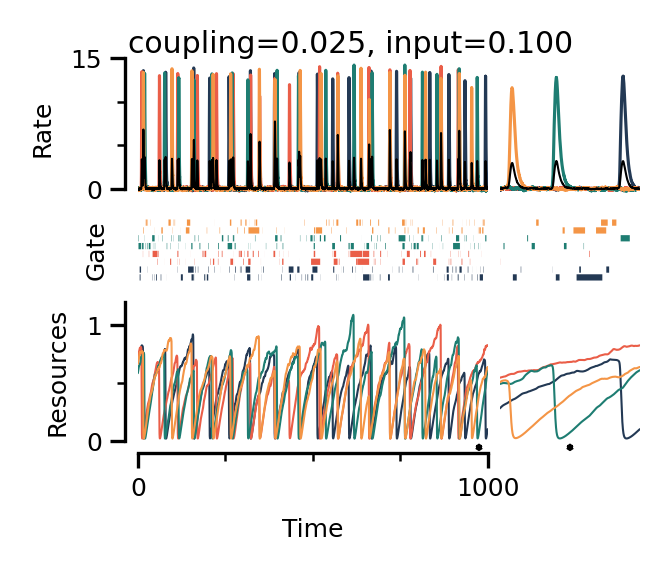

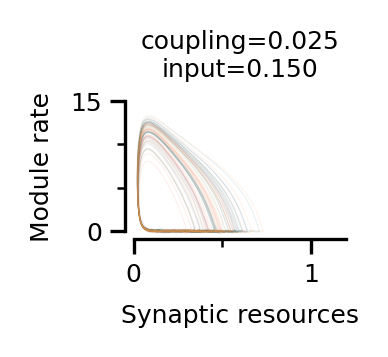

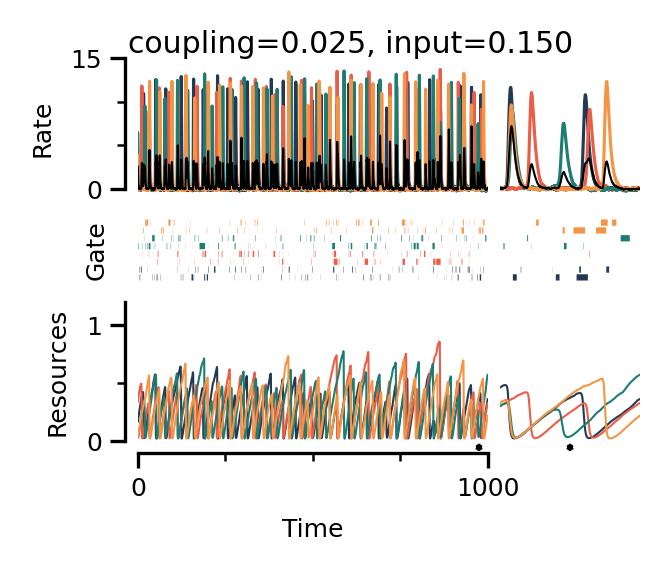

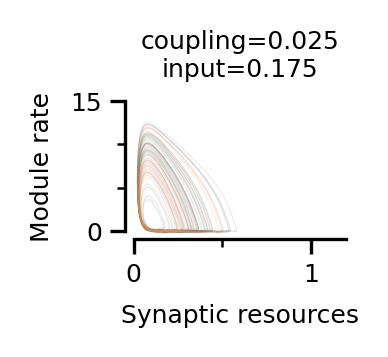

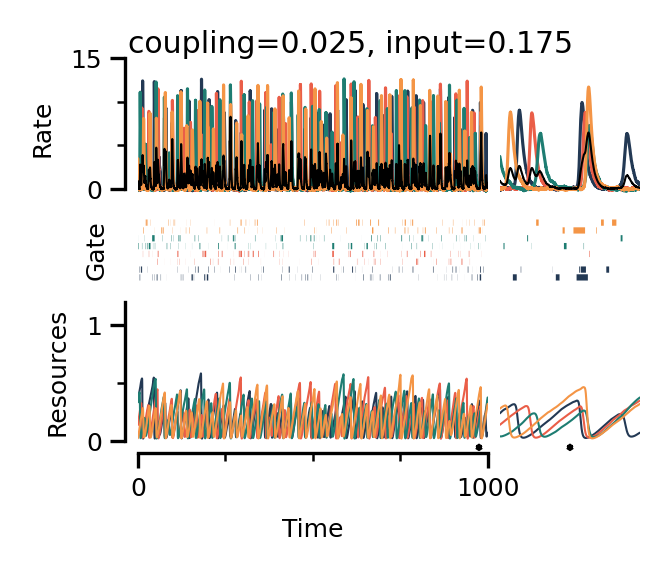

In [4]:
print(pp.fig_5_snapshots.__doc__)
pp.fig_5_snapshots()

## Interplay of noise and external input for individual modules


    Creates Suppl. Fig S7, exploring single-module dynamics in the mesoscopic model.

    * 3 panels showing the stationary (infinite time) solutions in different planes.
        - inputs go from low (blue) to medium (yellow) to high (red)
    * Matrix of flow fields
        - for increasting input strength h (left to right, matching colors from above)
        - and increasing noise intensity sigma (top to bottom)
        - gray lines indicate the trajectory a single module would _determinsitically_
            follow if placed at a given position in phase space
        - colored lines indicate actual trajectories, when the module is exposed
            to permutations due to the noise.
    


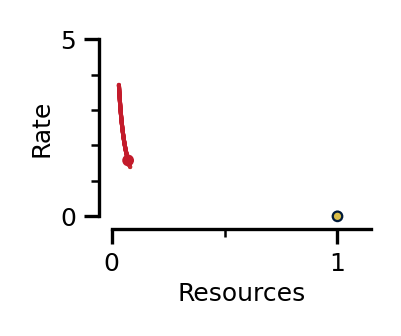

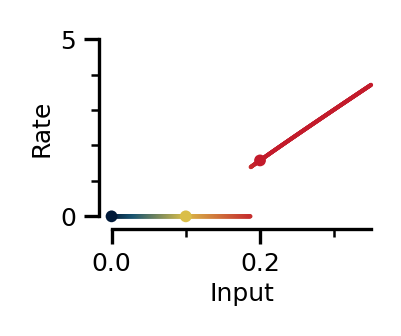

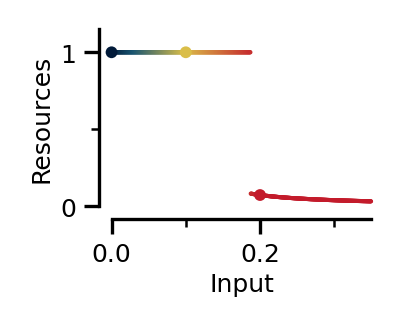

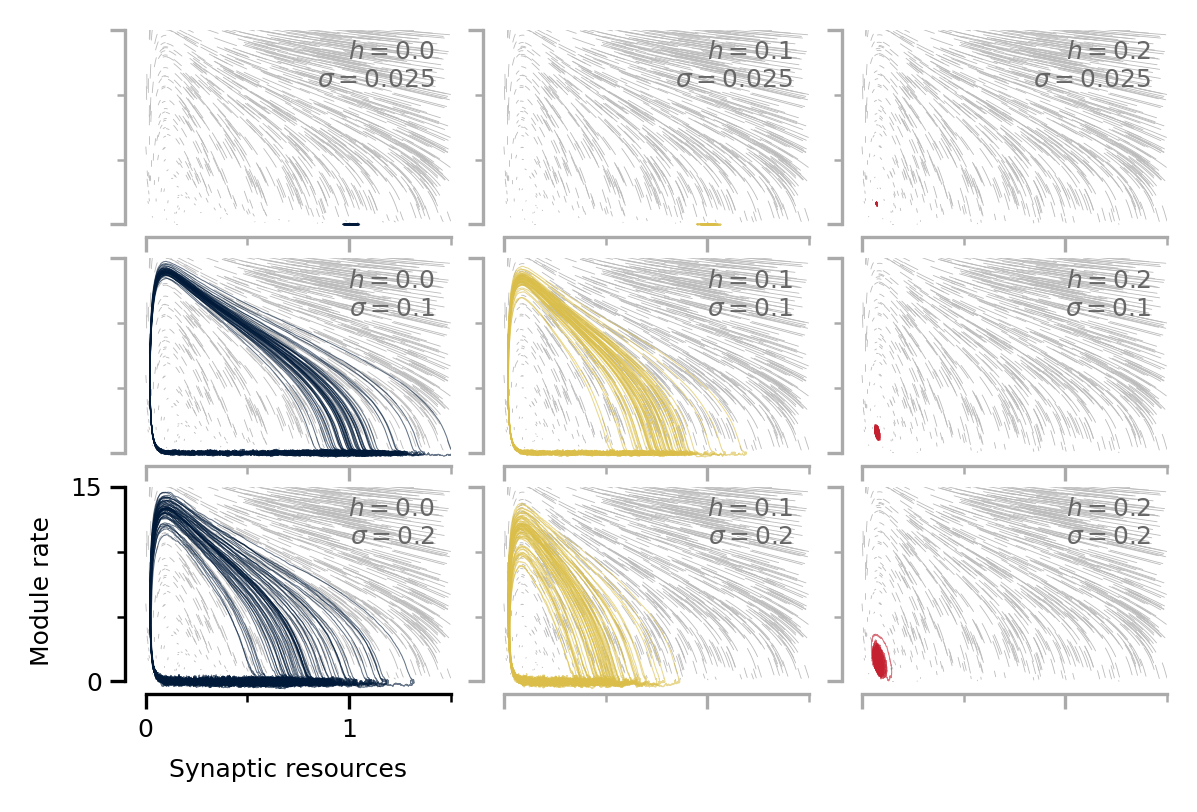

In [5]:
print(pp.fig_sm_meso_noise_and_input_flowfields.__doc__)
pp.fig_sm_meso_noise_and_input_flowfields()